In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
import torchvision
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os
import cv2



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),  # Flip the image horizontally with 100% probability
    transforms.RandomRotation((90, 90)),  # Rotate 90 degrees anti-clockwise
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
train_dataset = EMNIST(root='data/', split='byclass', train=True, download=True, transform=transform)
test_dataset = EMNIST(root='data/', split='byclass', train=False, download=True, transform=transform)

100.0%


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [5]:
classes = train_dataset.classes

In [6]:
def show_image(img, label, classes):
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {classes[label]}')
    plt.show()

In [7]:
#Only Run This if dataset is not in tensors

# for i in range(5):
    # image, label = train_dataset[i]
    # show_image(image, label, classes)

In [8]:
# Create DataLoader for training dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,  # Adjust batch size as needed
    shuffle=True,   # Shuffle the training data
    num_workers=2   # Number of subprocesses to use for data loading
)

# Create DataLoader for test dataset
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,  # Adjust batch size as needed
    shuffle=False,  # No need to shuffle the test data
    num_workers=2   # Number of subprocesses to use for data loading
)

In [9]:
# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 62)  # 62 classes in the 'byclass' split

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
                running_loss = 0.0

    print('Finished Training')

In [12]:
# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')


In [13]:
# Train the model
# train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)

In [14]:
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [15]:
# Evaluate the model
evaluate_model(model, test_loader, device)

Accuracy of the model on the test images: 86.45%


In [27]:
# Function to preprocess the image
def preprocess_image(image_path):
    # Open the image file
    img = Image.open(image_path).convert('L')  # Convert to grayscale ('L' mode)

    # Resize the image to 28x28
    img = img.resize((28, 28))

    # Display the resized image
    plt.figure()
    plt.title("Resized Image (28x28)")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    # Invert the colors
    img = ImageOps.invert(img)

    _, img = cv2.threshold(np.array(img), 127, 255, cv2.THRESH_BINARY)

    # Display the original grayscale image
    plt.figure()
    plt.title("Inverted Grayscale Image")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    # Define the transformations: convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Apply the transformations
    img_tensor = transform(img)

    # Add batch dimension (1, 1, 28, 28)
    img_tensor = img_tensor.unsqueeze(0)

    return img_tensor

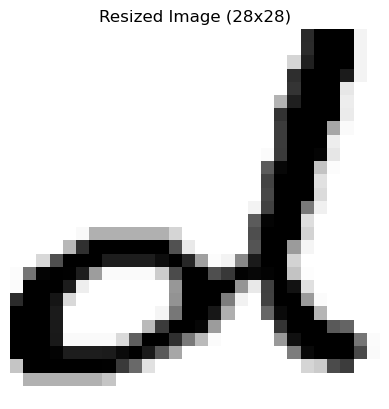

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'threshold'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [28]:
model.eval()  # Set the model to evaluation mode

# Function to predict the label of the processed image
def predict_image(model, image_tensor):
    with torch.no_grad():
        outputs = model(image_tensor)
        
        _, predicted = torch.max(outputs.data, 1)
        return predicted.item()

# Example usage
for file in os.listdir('letter_seg'):
    image_path = 'letter_seg/' + file  # Replace with your image path
    processed_image = preprocess_image(image_path)  # Process the image
    

    # Predict the label of the image
    predicted_label = predict_image(model, processed_image.to(device))
    print(f'Predicted Label: {predicted_label} | {classes[predicted_label]}')